In [1]:

import os
import re
from tqdm import tqdm


def bracket_filter(sentence, mode='phonetic'):
    new_sentence = str()

    if mode == 'phonetic':
        flag = False

        for ch in sentence:
            if ch == '(' and flag is False:
                flag = True
                continue
            if ch == '(' and flag is True:
                flag = False
                continue
            if ch != ')' and flag is False:
                new_sentence += ch

    elif mode == 'spelling':
        flag = True

        for ch in sentence:
            if ch == '(':
                continue
            if ch == ')':
                if flag is True:
                    flag = False
                    continue
                else:
                    flag = True
                    continue
            if ch != ')' and flag is True:
                new_sentence += ch

    else:
        raise ValueError("Unsupported mode : {0}".format(mode))

    return new_sentence


def special_filter(sentence, mode='phonetic', replace=None):
    SENTENCE_MARK = ['?', '!', '.']
    NOISE = ['o', 'n', 'u', 'b', 'l']
    EXCEPT = ['/', '+', '*', '-', '@', '$', '^', '&', '[', ']', '=', ':', ';', ',']

    new_sentence = str()
    for idx, ch in enumerate(sentence):
        if ch not in SENTENCE_MARK:
            if idx + 1 < len(sentence) and ch in NOISE and sentence[idx + 1] == '/':
                continue

        if ch == '#':
            new_sentence += '샾'

        elif ch == '%':
            if mode == 'phonetic':
                new_sentence += replace
            elif mode == 'spelling':
                new_sentence += '%'

        elif ch == '\n':
            continue
        elif ch not in EXCEPT:
            new_sentence += ch

    pattern = re.compile(r'\s\s+')
    new_sentence = re.sub(pattern, ' ', new_sentence.strip())
    return new_sentence


def sentence_filter(raw_sentence, mode, replace=None):
    return special_filter(bracket_filter(raw_sentence, mode), mode, replace)

``` json
{"audio_path": "wavs/visit_001.wav", "transcript": "안녕하세요 내원 목적은 ...", "language": "ko"}
{"audio_path": "wavs/visit_002.wav", "transcript": "요즘 기침이 심하고 ...",   "language": "ko"}
```

In [ ]:
import os
import json

filenames = [
    'AI_Hub_비대면진료/비대면_진료를_위한_의료진_및_환자_음성/Training/train.scp',
    'AI_Hub_비대면진료/비대면_진료를_위한_의료진_및_환자_음성/Validation/valid.scp'
]

def scp_to_jsonl(scp_files, output_files):
    for scp_file, output_file in zip(scp_files, output_files):
        with open(scp_file, 'r', encoding='utf-8') as fin, open(output_file, 'w', encoding='utf-8') as fout:
            for line in fin:
                cleaned_line = line.strip()
                if cleaned_line:
                    parts = cleaned_line.split('|', 1)
                    if len(parts) == 2:
                        obj = {
                            "audio_path": parts[0],
                            "transcript": parts[1],
                            "language": "ko"
                        }
                        fout.write(f"{json.dumps(obj, ensure_ascii=False)}\n")

scp_to_jsonl(
    filenames,
    ["train_data.jsonl", "validation_data.jsonl"]
)

Processing medical_manifest.jsonl: 100%|██████████████████████| 141819/141819 [04:54<00:00, 481.54it/s]


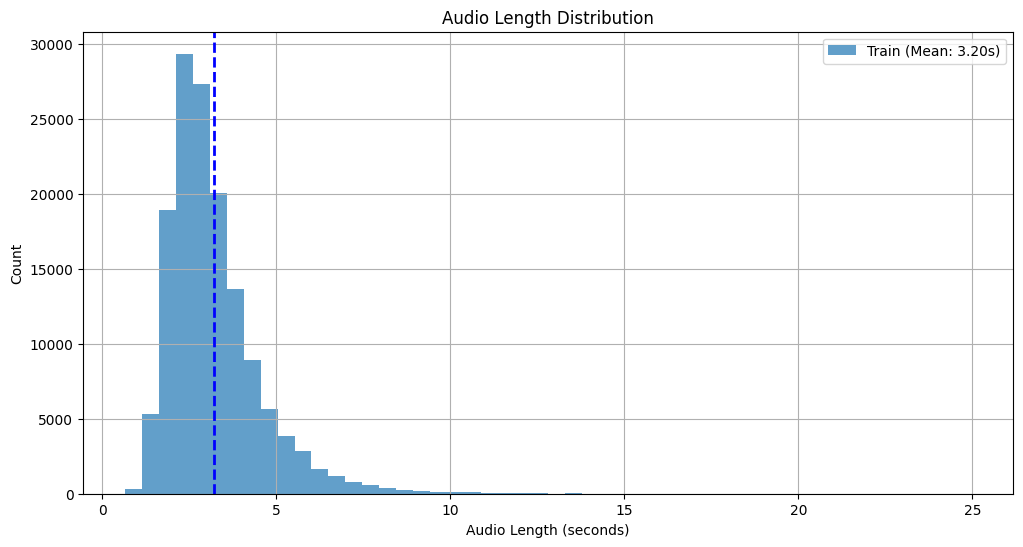

In [ ]:
import json
import os
import soundfile as sf  # librosa 대신 soundfile 임포트
import matplotlib.pyplot as plt
from tqdm import tqdm      # tqdm 임포트

def get_audio_lengths(jsonl_file):
    """오디오 파일의 길이를 효율적으로 계산합니다."""
    lengths = []
    
    # 파일의 총 라인 수를 먼저 계산하여 tqdm에 사용
    with open(jsonl_file, 'r', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)

    with open(jsonl_file, 'r', encoding='utf-8') as f:
        # tqdm을 적용하여 프로그레스 바 표시
        for line in tqdm(f, total=total_lines, desc=f"Processing {os.path.basename(jsonl_file)}"):
            data = json.loads(line)
            audio_path = data.get("audio_path")
            
            if audio_path and os.path.exists(audio_path):
                try:
                    # soundfile로 헤더 정보만 빠르게 읽기
                    info = sf.info(audio_path)
                    duration = info.frames / info.samplerate
                    lengths.append(duration)
                except Exception as e:
                    print(f"Error processing {audio_path}: {e}")
                    continue
    return lengths

# --- 데이터 로드 및 시각화 (기존 코드와 동일) ---

train_lengths = get_audio_lengths("dataset/medical_manifest.jsonl")
# valid_lengths = get_audio_lengths("validation_data.jsonl")

# 평균 길이 계산 (시각화에 추가)
train_mean = sum(train_lengths) / len(train_lengths) if train_lengths else 0
# valid_mean = sum(valid_lengths) / len(valid_lengths) if valid_lengths else 0

plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, label=f'Train (Mean: {train_mean:.2f}s)')
# plt.hist(valid_lengths, bins=50, alpha=0.7, label=f'Validation (Mean: {valid_mean:.2f}s)')

# 평균 길이를 나타내는 세로선 추가
plt.axvline(train_mean, color='blue', linestyle='dashed', linewidth=2)
# plt.axvline(valid_mean, color='orange', linestyle='dashed', linewidth=2)

plt.xlabel('Audio Length (seconds)')
plt.ylabel('Count')
plt.title('Audio Length Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# train/validation 데이터셋의 오디오 길이의 최소, 최대값을 출력합니다.

if train_lengths:
    print(f"Train 데이터셋: 최소 길이 = {min(train_lengths):.2f}초, 최대 길이 = {max(train_lengths):.2f}초")
else:
    print("Train 데이터셋에 유효한 오디오가 없습니다.")

# if valid_lengths:
#     print(f"Validation 데이터셋: 최소 길이 = {min(valid_lengths):.2f}초, 최대 길이 = {max(valid_lengths):.2f}초")
# else:
#     print("Validation 데이터셋에 유효한 오디오가 없습니다.")
